In [1]:
import pandas as pd
import json

def load_jsonl(path):
    with open(path, 'r') as f:
        return [json.loads(line) for line in f]

train_data = load_jsonl('E:/NLP/MathQA_MAS/grade_school_math/train.jsonl')
test_data = load_jsonl('E:/NLP/MathQA_MAS/grade_school_math/test.jsonl')

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

print(df_train.head())

                                            question  \
0  Natalia sold clips to 48 of her friends in Apr...   
1  Weng earns $12 an hour for babysitting. Yester...   
2  Betty is saving money for a new wallet which c...   
3  Julie is reading a 120-page book. Yesterday, s...   
4  James writes a 3-page letter to 2 different fr...   

                                              answer  
0  Natalia sold 48/2 = <<48/2=24>>24 clips in May...  
1  Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...  
2  In the beginning, Betty has only 100 / 2 = $<<...  
3  Maila read 12 x 2 = <<12*2=24>>24 pages today....  
4  He writes each friend 3*2=<<3*2=6>>6 pages a w...  


In [2]:
print(f"Train size: {len(df_train)}")
print(f"Test size: {len(df_test)}")

print(df_train.isnull().sum())

df_train['question_length'] = df_train['question'].apply(lambda x: len(x.split()))
df_train['answer_length'] = df_train['answer'].apply(lambda x: len(x.split()))

print(df_train[['question_length', 'answer_length']].describe())


Train size: 7473
Test size: 1319
question    0
answer      0
dtype: int64
       question_length  answer_length
count      7473.000000    7473.000000
mean         45.092600      51.711762
std          17.482279      26.731678
min           9.000000       4.000000
25%          33.000000      32.000000
50%          42.000000      47.000000
75%          54.000000      66.000000
max         183.000000     216.000000


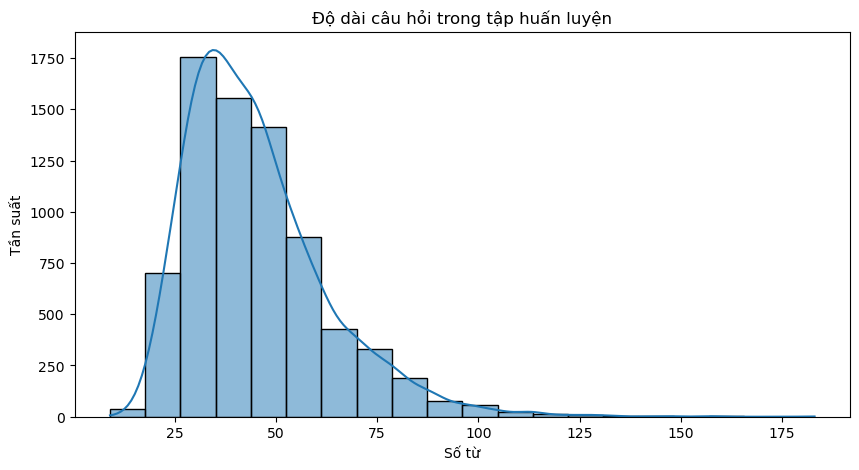

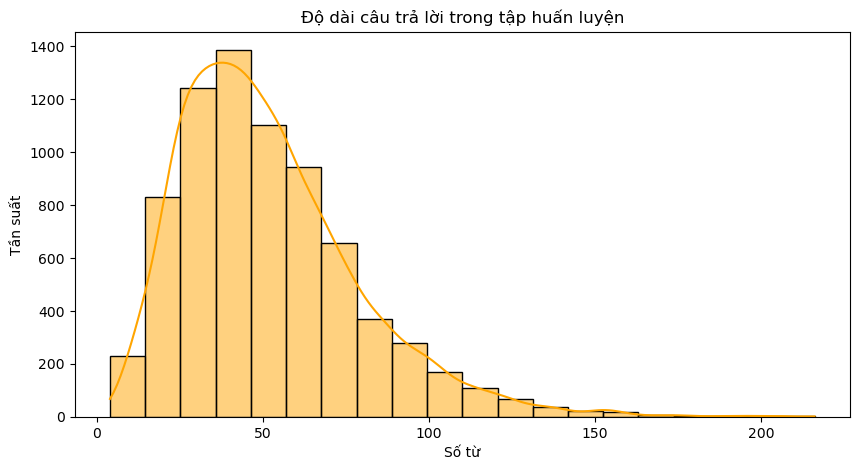

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Biểu đồ độ dài câu hỏi
plt.figure(figsize=(10, 5))
sns.histplot(df_train['question_length'], kde=True, bins=20)
plt.title('Độ dài câu hỏi trong tập huấn luyện')
plt.xlabel('Số từ')
plt.ylabel('Tần suất')
plt.show()

# Biểu đồ độ dài đáp án
plt.figure(figsize=(10, 5))
sns.histplot(df_train['answer_length'], kde=True, bins=20, color='orange')
plt.title('Độ dài câu trả lời trong tập huấn luyện')
plt.xlabel('Số từ')
plt.ylabel('Tần suất')
plt.show()

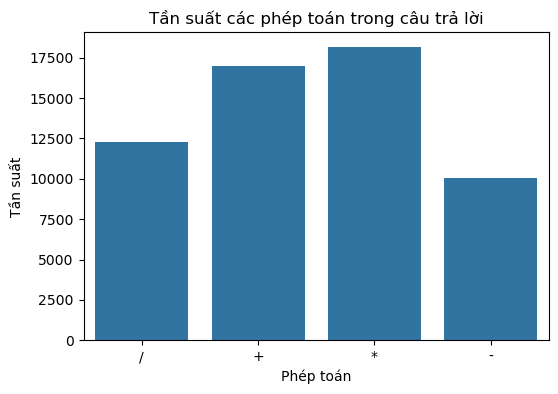

In [4]:
import re
from collections import Counter

def extract_operations(answer):
    return re.findall(r'[\+\-\*/]', answer)

df_train['operations'] = df_train['answer'].apply(extract_operations)
all_ops = [op for sublist in df_train['operations'] for op in sublist]
op_counts = Counter(all_ops)

plt.figure(figsize=(6, 4))
sns.barplot(x=list(op_counts.keys()), y=list(op_counts.values()))
plt.title('Tần suất các phép toán trong câu trả lời')
plt.xlabel('Phép toán')
plt.ylabel('Tần suất')
plt.show()

Phép nhân và phép cộng là hai phép toán phổ biến nhất, chiếm ưu thế rõ rệt so với phép chia và phép trừ.
Sự khác biệt giữa các phép toán không quá lớn, nhưng phép trừ có xu hướng xuất hiện ít hơn các phép khác.

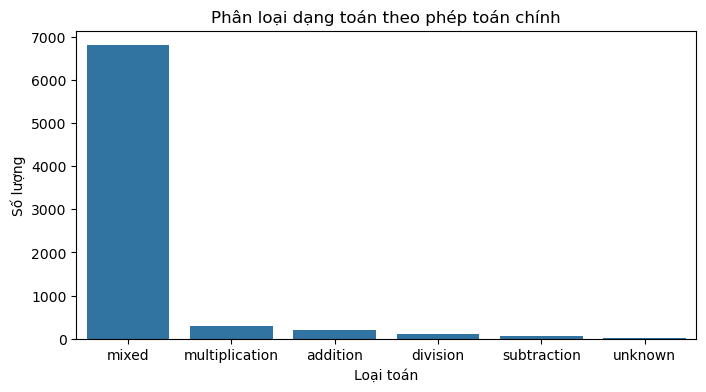

In [ ]:
def categorize_problem(ops):
    if not ops:
        return "unknown"
    unique_ops = set(ops)
    if unique_ops == {'+'}:
        return 'addition'
    elif unique_ops == {'-'}:
        return 'subtraction'
    elif unique_ops == {'*'}:
        return 'multiplication'
    elif unique_ops == {'/'}:
        return 'division'
    elif len(unique_ops) > 1:
        return 'mixed'
    return 'other'

df_train['category'] = df_train['operations'].apply(categorize_problem)

plt.figure(figsize=(8, 4))
sns.countplot(data=df_train, x='category', order=df_train['category'].value_counts().index)
plt.title('Phân loại dạng toán theo phép toán chính')
plt.xlabel('Loại toán')
plt.ylabel('Số lượng')
plt.show()

Loại toán "mixed" (hỗn hợp) chiếm số lượng lớn nhất, với khoảng 6.500 đến 7.000 bài toán. Điều này cho thấy tập dữ liệu có nhiều bài toán kết hợp nhiều phép tính (cộng, trừ, nhân, chia) hoặc các bài toán phức tạp hơn.
Các loại phép toán khác (multiplication - nhân, addition - cộng, division - chia, subtraction - trừ, unknown - không xác định) có số lượng rất thấp, dao động từ 0 đến khoảng 500 bài toán mỗi loại.
Loại "unknown" gần như không có dữ liệu đáng kể, cho thấy tập dữ liệu đã được phân loại tốt và ít bài toán không rõ loại.

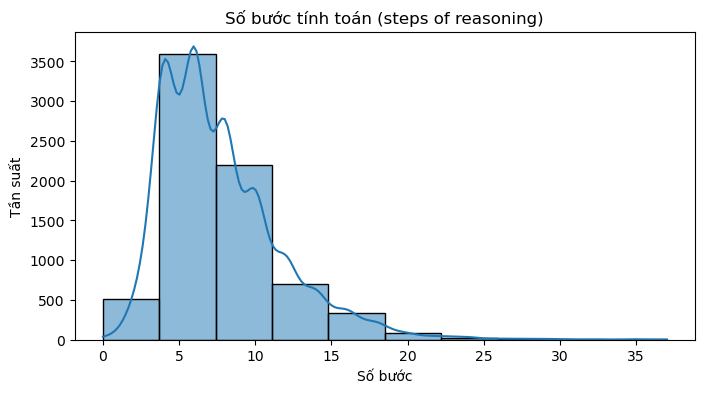

                                               question  \
3402  A movie theater company is advertising a deal ...   
2744  Ben's potato gun can launch a potato 6 footbal...   
4756  Sasha heard that planting trees helps to reduc...   

                                                 answer  
3402  The popcorn costs 8 - 3 = $<<8-3=5>>5.\nThe dr...  
2744  First find the total distance the potato flies...  
4756  The temperature dropped 1.8 degrees because 80...  


In [ ]:
# Tính số phép toán (coi là số bước logic)
df_train['num_steps'] = df_train['answer'].str.count(r'[+\-*/]')

# Biểu đồ số bước suy luận
plt.figure(figsize=(8, 4))
sns.histplot(df_train['num_steps'], bins=10, kde=True)
plt.title('Số bước tính toán (steps of reasoning)')
plt.xlabel('Số bước')
plt.ylabel('Tần suất')
plt.show()
# In ra ví dụ có >2 bước
print(df_train[df_train['num_steps'] > 2][['question', 'answer']].sample(3))


Biểu đồ "Số bước tính toán (steps of reasoning)" cho thấy:

- Phần lớn bài toán có số bước từ 0 đến 5, với đỉnh cao nhất khoảng 3.500 lần tại 0-2 bước.
- Số bước tăng dần giảm mạnh sau 5, với rất ít bài toán có trên 15 bước.
- Phân phối lệch phải, cho thấy đa số bài toán đơn giản, ít bước logic, phù hợp với cấp tiểu học.

In [7]:
def extract_expressions(answer):
    # Trích xuất các dòng có phép toán
    return re.findall(r'[^\n]*[0-9\s\+\-\*/=]+[^\n]*', answer)

df_train['expressions'] = df_train['answer'].apply(extract_expressions)

# In thử vài dòng
for i in range(3):
    print("Câu hỏi:", df_train.iloc[i]['question'])
    print("Biểu thức:")
    print(df_train.iloc[i]['expressions'])
    print("-" * 40)

Câu hỏi: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Biểu thức:
['Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.', '\n#### 72']
----------------------------------------
Câu hỏi: Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?
Biểu thức:
['Weng earns 12/60 = $<<12/60=0.2>>0.2 per minute.\nWorking 50 minutes, she earned 0.2 x 50 = $<<0.2*50=10>>10.', '\n#### 10']
----------------------------------------
Câu hỏi: Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?
Biểu thức:
["In the beginning, Betty has only 100 / 2 = $<<100/2=50>>50.\n

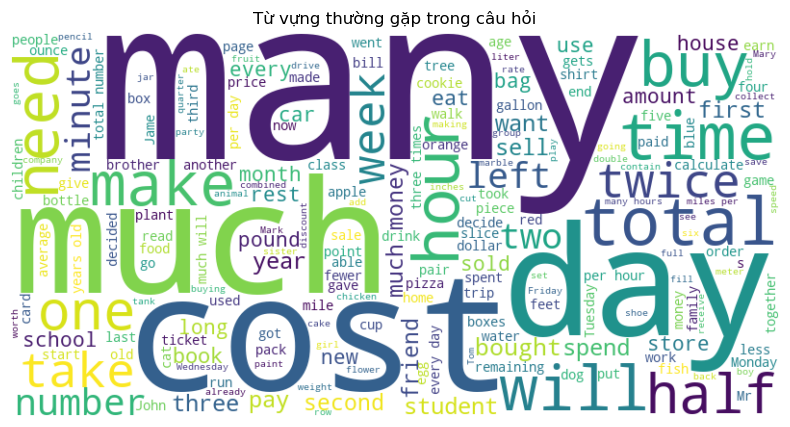

In [ ]:
from wordcloud import WordCloud

all_text = " ".join(df_train['question'].tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Từ vựng thường gặp trong câu hỏi')
plt.show()

Word cloud "Từ vựng thường gặp trong câu hỏi" cho thấy:

- Các từ phổ biến nhất: "many", "buy", "want", "twice", "total", "day" (cỡ chữ lớn).
- Chủ đề chính: Mua bán (buy, sell, cost, money), thời gian (day, week, year), số lượng (many, much, twice, half), và danh từ quen thuộc (car, house, apple, pizza).
- Insight: Câu hỏi tập trung vào các bài toán thực tế liên quan đến giao dịch, đếm số lượng, và đo lường thời gian, phù hợp với toán tiểu học.

Top đơn vị đo thường gặp: [('hours', 692), ('minutes', 655), ('of', 644), ('more', 596), ('times', 553), ('each', 543), ('miles', 455), ('years', 443), ('per', 410), ('and', 396)]


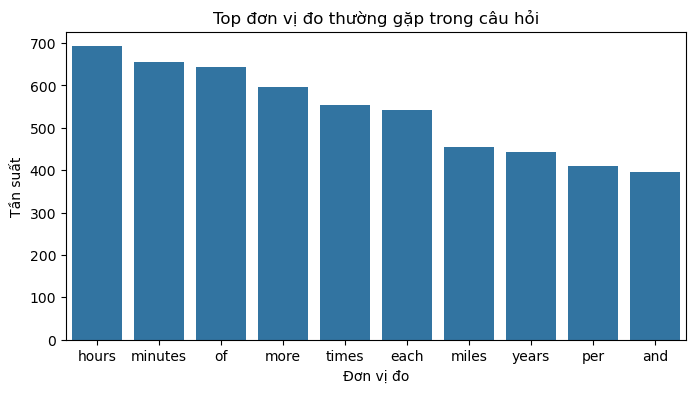

In [10]:
import re
from collections import Counter

# Trích xuất các đơn vị đo (sau chữ số)
def extract_units(q):
    return re.findall(r'\b\d+\s+([a-zA-Z]+)', q)

unit_list = df_train['question'].apply(extract_units)
all_units = [unit.lower() for sub in unit_list for unit in sub]

unit_counts = Counter(all_units).most_common(10)
print("Top đơn vị đo thường gặp:", unit_counts)

# Biểu đồ
plt.figure(figsize=(8, 4))
sns.barplot(x=[u[0] for u in unit_counts], y=[u[1] for u in unit_counts])
plt.title('Top đơn vị đo thường gặp trong câu hỏi')
plt.xlabel('Đơn vị đo')
plt.ylabel('Tần suất')
plt.show()

Biểu đồ "Top từ vựng thường gặp trong câu hỏi" cho thấy:

- Các từ "hours", "minutes", và "of" có tần suất cao nhất (khoảng 700 lần), phản ánh sự tập trung vào thời gian và sở hữu.
- "Times", "each", "more", và "Dan vi do" (có thể là lỗi đánh máy hoặc từ ngữ cụ thể) cũng phổ biến (500-600 lần).
- Từ "years", "miles", "per", và "and" giảm dần (300-400 lần).
- Insight: Câu hỏi tập trung vào các bài toán liên quan đến thời gian, đo lường, và so sánh, phù hợp với ngữ cảnh thực tế trong toán tiểu học.